In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, vstack
import astropy.units as u

# from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA

import sompy

def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

def mag_snr(magerr):
    return 2.5 / (np.log(10) * magerr)

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

## SOMPY test

In [ ]:
#import GAMA
with fits.open('/data2/lsajkov/mpdg/data/GAMA/GAMA_mstars_concat.fits') as hdu:
    GAMA_mstar_concat = Table(hdu[1].data)

In [49]:
#produce magnitude columns
GAMA_fluxJy_r = GAMA_mstar_concat['flux_rt'] * u.Jansky
GAMA_fluxerrJy_r = GAMA_mstar_concat['flux_err_rt']

GAMA_fluxJy_g = GAMA_mstar_concat['flux_gt'] * u.Jansky
GAMA_fluxerrJy_g = GAMA_mstar_concat['flux_err_gt']

GAMA_mag_r = GAMA_fluxJy_r.to(u.ABmag).value
GAMA_magerr_r = errJy_to_errABmag(GAMA_fluxJy_r, GAMA_fluxerrJy_r).value

GAMA_mag_g = GAMA_fluxJy_g.to(u.ABmag).value
GAMA_magerr_g = errJy_to_errABmag(GAMA_fluxJy_g, GAMA_fluxerrJy_g).value

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [52]:
#produce additional columns

#g-r color columns
GAMA_gr_color = GAMA_mstar_concat['absmag_g'] - GAMA_mstar_concat['absmag_r']
GAMA_gr_color_err =  np.hypot(GAMA_magerr_g, GAMA_magerr_r)

#effective surface brightness column
GAMA_mu_r_eff = GAMA_mag_r + 2.5 * np.log10(2 * np.pi * GAMA_mstar_concat['R50'] ** 2)

/var/tmp/lsajkov/ipykernel_3684298/549838973.py:8: RuntimeWarning: overflow encountered in square
  GAMA_mu_r_eff = GAMA_mag_r + 2.5 * np.log10(2 * np.pi * GAMA_mstar_concat['R50'] ** 2)


In [54]:
#vectorize
GAMA_vect_data = Table([GAMA_mstar_concat['uberID_1'],
                        GAMA_mag_r, GAMA_magerr_r,
                        GAMA_gr_color, GAMA_gr_color_err,
                        GAMA_mu_r_eff,
                        GAMA_mstar_concat['logmstar'],
                        GAMA_mstar_concat['Z']],
                        names = ['ID',
                                 'r_mag', 'r_mag_err',
                                 'surf_bright_r',
                                 'gr_color', 'gr_color_err',
                                 'log_stellar_mass',
                                 'redshift'
                        ])

In [53]:
#define primary targeting region
def gr_color_condition(gr_color, gr_color_err,
               r_mag):
    
    return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9


def surf_bright_condition(surf_bright_r, surf_bright_r_err,
                                 r_mag):
    
    return (surf_bright_r + surf_bright_r_err\
            - 0.7 * (r_mag - 14)) > 18.5

In [57]:
#produce primary targeting region
gr_color_mask    = gr_color_condition(GAMA_vect_data['gr_color'],
                                      GAMA_vect_data['gr_color_err'],
                                      GAMA_vect_data['r_mag'])

surf_bright_mask = surf_bright_condition(GAMA_vect_data['surf_bright_r'],
                                         GAMA_vect_data['r_mag_err'],
                                         GAMA_vect_data['r_mag'])

in_prim_targ_reg = gr_color_mask & surf_bright_mask

In [67]:
#very conservative snr cut to save on computation
GAMA_idx = (GAMA_mstar_concat['snratio'] > 105) &\
           (GAMA_mstar_concat['logmstar'] > 3)

print(f'With this cut, {np.sum(GAMA_idx)}/{len(GAMA_idx)} objects are kept')

With this cut, 35982/370116 objects are kept


In [ ]:
#plot data
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

mstar_gama = ax.scatter(GAMA_mag_r[GAMA_idx],
                        GAMA_mstar_concat[GAMA_idx]['absmag_g'] - GAMA_mstar_concat[GAMA_idx]['absmag_r'],
                        s = 3, c = GAMA_mstar_concat[GAMA_idx]['logmstar'],
                        alpha = 0.75)

ax.set_xlabel('$r$')
ax.set_ylabel('$r_{\mathrm{abs}}-g_{\mathrm{abs}}$')

fig.colorbar(mstar_gama, label = 'log$(M_*/M_{\odot})$')


In [68]:
rmag_list     = list(GAMA_mag_r[GAMA_idx].value)
gr_col_list   = list(GAMA_mstar_concat[GAMA_idx]['absmag_g'] - GAMA_mstar_concat[GAMA_idx]['absmag_r'])
logmstar_list = list(GAMA_mstar_concat[GAMA_idx]['logmstar'])

SOMready_data = np.array(list(zip(rmag_list, gr_col_list, logmstar_list)))

In [72]:
mapsize = [30, 30]

SOM = sompy.SOMFactory.build(SOMready_data,
                             mapsize = mapsize,
                             component_names = ['r_mag', 'gr_color', 'logmstar'])

In [73]:
SOM.train(n_job = 1, verbose = 'info')

 Training...
 pca_linear_initialization took: 0.014000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 7

 epoch: 1 ---> elapsed time:  0.163000, quantization error: 0.763935

 epoch: 2 ---> elapsed time:  0.179000, quantization error: 0.529711

 epoch: 3 ---> elapsed time:  0.196000, quantization error: 0.388598

 epoch: 4 ---> elapsed time:  0.220000, quantization error: 0.323609

 epoch: 5 ---> elapsed time:  0.106000, quantization error: 0.280181

 epoch: 6 ---> elapsed time:  0.188000, quantization error: 0.242759

 epoch: 7 ---> elapsed time:  0.193000, quantization error: 0.209963

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.117000, quantization error: 0.178168

 epoch: 2 ---> elapsed time:  0.192000, quantization error: 0.170193

 epoch: 3 ---> elapsed time:  0.172000, quantization error: 0.167515

 epoch: 4 ---> elapsed time:  0.180000, quantization error: 0.166193

 ep

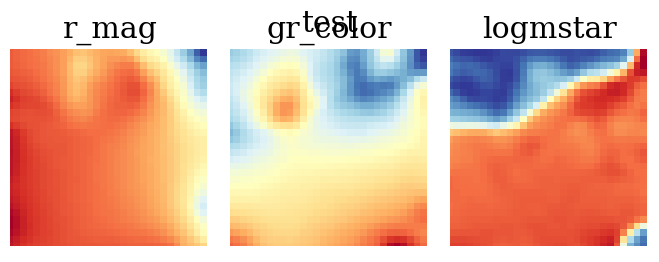

In [74]:
SOM_plot = sompy.mapview.View2DPacked(30, 30, 'test', text_size = 18)
SOM_plot.show(SOM)